<h3>DATA PREPROCESSING</h3>

In [1]:
import os
import gc
import random
import time
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.transforms import Compose
from torchvision.models import vgg19
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
import wandb

In [2]:
class DF2KDataset(Dataset):
    def __init__(self, hr_images_path, random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989):
        super(DF2KDataset, self).__init__()
        
        self.hr_images_path = hr_images_path
        
        hr_images_list = os.listdir(hr_images_path)
        
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list]
        
        self.random_crop = random_crop
        self.transforms = transforms
        self.output_size = output_size
        self.seed = seed
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('.png', 'x4.png').replace('HR', 'LR_bicubic_X4')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        # -------------------- RANDOM CROP -------------------- #
        if self.random_crop:
            w, h = hr_image.size
            th, tw = self.output_size
            random.seed(self.seed + idx)
            i = random.choice(list(range(0, h-th+1, 4)))
            j = random.choice(list(range(0, w-tw+1, 4)))

            hr_image = transforms.functional.crop(hr_image, i, j, th, tw)
            lr_image = transforms.functional.crop(lr_image, i//4, j//4, th//4, tw//4)
            
        # -------------------- TO TENSOR -------------------- #
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        # -------------------- OTHER TRANSFORMATIONS -------------------- #
        if self.transforms:
            torch.manual_seed(seed=self.seed)
            hr_image = self.transforms(hr_image)
            torch.manual_seed(seed=self.seed)
            lr_image = self.transforms(lr_image)
        
        return hr_image, lr_image
        
    def __len__(self):
        return len(self.hr_images_list)

In [3]:
class DF2KDataLoader(DataLoader):
    def __init__(self, hr_images_path, 
                 random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989,
                 batch_size:int=16, shuffle:bool=True, num_crops:int=1):
        """
        - hr_images_path: str
            Path to the high-resolution images
        - random_crop: bool
            Whether to crop the images. Default is True. You might want to crop on the training set, but not on the validation set.
        - transforms: Compose
            A Compose of transformations, applied similarly on both high-res and low-res images.
            >> NOTE: Some transformations might worsen the quality of image, so consider carefully.
        - output_size: tuple
            Size of the random crop applied to an image. Default is 256x256.
            >> NOTE: Only meaningful when `random_crop` is True.
        - seed: int
            A random number, meant to keep all transformations the same for high-res and low-res images
        - num_crops: int
            The number of random crops applied to an image. Size of dataset is multiplied accordingly. Default is 1.
            >> NOTE: Only meaningful when `random_crop` is True.
        """
        if random_crop and num_crops > 1:
            random.seed(1989)
            sub_datasets = [DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed+int(random.random()*10)) 
                            for _ in range(num_crops)]
            self.dataset = ConcatDataset(sub_datasets)
        else:
            self.dataset = DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed)
        super().__init__(self.dataset, batch_size=batch_size, shuffle=shuffle)

### EXAMPLE USAGE

In [4]:
HR_IMAGES_PATH_TRAIN = "/kaggle/input/df2k-with-bicubic-x4/dataset/DF2K_train_HR/"
HR_IMAGES_PATH_VALID = "/kaggle/input/df2k-with-bicubic-x4/dataset/DIV2K_valid_HR/"

class RandomRotation(object):
    def __call__(self, img):
        rotation_angle = torch.randint(0,3,(1,)).item()* 90
        return transforms.functional.rotate(img, rotation_angle)

TRANSFORMS = Compose([
    transforms.RandomHorizontalFlip(),
    RandomRotation()
])
# NOTE: Refer to the source code above to navigate the paramters when initializing a DataLoader for this dataset.
train_dataloader = DF2KDataLoader(hr_images_path=HR_IMAGES_PATH_TRAIN,
                                  random_crop=True, transforms=TRANSFORMS, output_size=(256, 256),seed=1989,
                                  batch_size=16, shuffle=True, num_crops=1)
# NOTE: For the validation dataloader, batch_size should always be 1, because the dimensions of each picture are 
# different, making them unstackable in the dataloader. In the case you do not want to do so, let random_crop be 
# True and add an output_size, and num_crops if you would like to have multiple crops per validation image.
valid_dataloader = DF2KDataLoader(hr_images_path=HR_IMAGES_PATH_VALID,
                                  random_crop=False, transforms=None, seed=1989,
                                  batch_size = 1, shuffle=False)

Length of train_dataloader: 216
>> Size of high-res image: torch.Size([256, 256, 3])
>> Size of low-res image: torch.Size([64, 64, 3])


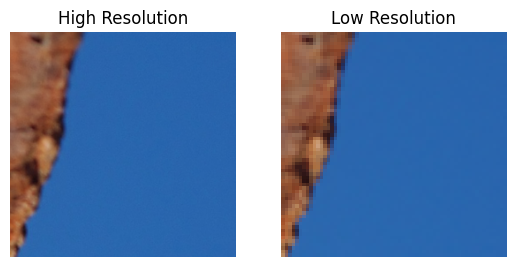

In [5]:
print("Length of train_dataloader: {}".format(len(train_dataloader)))
hrs, lrs = next(iter(train_dataloader))

hr = hrs[0].permute((1, 2, 0))
lr = lrs[0].permute((1, 2, 0))

print(">> Size of high-res image:", hr.size())
print(">> Size of low-res image:", lr.size())
fig, axs = plt.subplots(1, 2)

axs[0].imshow(hr)
axs[0].set_title('High Resolution')
axs[1].imshow(lr)
axs[1].set_title('Low Resolution')

for ax in axs.flat:
    ax.axis('off')

plt.show()

Length of valid_dataloader: 100
>> Size of high-res image: torch.Size([1416, 2040, 3])
>> Size of low-res image: torch.Size([354, 510, 3])


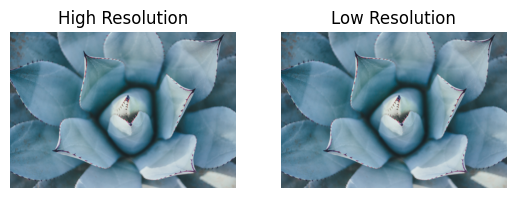

In [6]:
print("Length of valid_dataloader: {}".format(len(valid_dataloader)))
hrs, lrs = next(iter(valid_dataloader))

hr = hrs[0].permute((1, 2, 0))
lr = lrs[0].permute((1, 2, 0))

print(">> Size of high-res image:", hr.size())
print(">> Size of low-res image:", lr.size())
fig, axs = plt.subplots(1, 2)

axs[0].imshow(hr)
axs[0].set_title('High Resolution')
axs[1].imshow(lr)
axs[1].set_title('Low Resolution')

for ax in axs.flat:
    ax.axis('off')

plt.show()

<h3>MODEL</h3>

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )
    
    def forward(self, x):
        return x + self.conv_block(x)

In [8]:
class GeneratorResnet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResnet, self).__init__()
        #first layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())
        
        #Residual blocks
        res_blocks=[]
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)
        
        #second conv layer after res blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))
        upsampling=[]
        for _ in range(2):
            upsampling+=[
                nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)
        
        self.conv3 = nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [9]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        
        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2**4), int(in_width / 2**4)
        self.output_shape = (1, patch_h, patch_w)
        
        def discriminator_block(in_filters, out_filters, first_block=False):
            layers=[]
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        layers=[]
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i==0)))
            in_filters = out_filters
        layers.append(nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1))
        layers.append(nn.BatchNorm2d(512))
        layers.append(nn.LeakyReLU(0.2))
        output_layers=[nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)]
        layers.extend(output_layers)
        self.model = nn.Sequential(*layers)
        
    def forward(self, img):
        batch_size = img.size(0)
        return torch.sigmoid(self.model(img).view(batch_size))

In [10]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg19(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad=False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()
        
    def forward(self, out_labels, out_img, target_img):
        #adversarial loss
        adversarial_loss = torch.mean(1-out_labels)
        #perception loss
        perception_loss = self.mse_loss(self.loss_network(out_img), self.loss_network(target_img))
        #image loss
        image_loss = self.mse_loss(out_img, target_img)
        #tv loss
        tv_loss = self.tv_loss(out_img)
        return image_loss + 0.001*adversarial_loss + 0.006*perception_loss + 2e-8*tv_loss
    
class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight
        
    def forward(self, img):
        batch_size = img.size()[0]
        h = img.size()[2]
        w = img.size()[3]
        count_h = self.tensor_size(img[:,:,1:,:])
        count_w = self.tensor_size(img[:,:,:,1:])
        h_tv = torch.pow(img[:,:,1:,:] - img[:,:,:h-1,:], 2).sum()
        w_tv = torch.pow(img[:,:,:,1:] - img[:,:,:,:w-1], 2).sum()
        return self.tv_loss_weight * 2 * (h_tv/count_h + w_tv/count_w)/batch_size
        
    def tensor_size(self, x):
        return x.size()[1]*x.size()[2]*x.size()[3]

<h3>TRAINING</h3>

In [11]:
#settings
N_EPOCHS = 40
BATCH_SIZE = 16
G_LR = 0.001
D_LR = 1e-5
b1 = 0.9
b2 = 0.999
BETAS = (b1, b2)
STEP_SIZE=10
EPS = 1e-08
GAMMA = 0.67
CHANNELS = 3
hr_img_shape = (256,256)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
DEVICE

device(type='cuda')

In [13]:
class Network:
    def __init__(self, for_inference=False, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                 g_lr=G_LR, d_lr = D_LR, betas = BETAS, step_size = STEP_SIZE, device = DEVICE,
                 num_epochs = N_EPOCHS,eps = EPS, gamma = GAMMA, run_id=None):
        self.for_inference = for_inference
        self.generator = GeneratorResnet().to(device)
        self.discriminator = Discriminator(input_shape = (CHANNELS,*hr_img_shape)).to(device)
        self.device = device
        if not self.for_inference:
            self.generator_loss = GeneratorLoss().to(device)
            self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=g_lr, betas=BETAS, eps=eps)
            self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=d_lr, betas=BETAS, eps=eps)
            self.scheduler_G =  torch.optim.lr_scheduler.StepLR(self.optimizer_G, step_size=step_size, gamma=gamma)
            self.scheduler_D =  torch.optim.lr_scheduler.StepLR(self.optimizer_D, step_size=step_size, gamma=gamma)
            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.num_epochs = num_epochs

            self.run_id = run_id
    
    def save_network(self, epoch, G_train_loss, G_valid_loss, D_train_loss, D_valid_loss, checkpoint_path):
        checkpoint = {
            'epoch': epoch,
            'G_train_loss': G_train_loss,
            'G_valid_loss': G_valid_loss,
            'D_train_loss': D_train_loss,
            'D_valid_loss': D_valid_loss,
            'generator': self.generator.state_dict(),
            'discriminator': self.discriminator.state_dict(),
            'G_optimizer': self.optimizer_G.state_dict(),
            'D_optimizer': self.optimizer_D.state_dict(),
            'G_lr_scheduler': self.scheduler_G.state_dict(),
            'D_lr_scheduler': self.scheduler_D.state_dict(),
            'network': self
        }
        torch.save(checkpoint, checkpoint_path)
    
    def load_network(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.generator.load_state_dict(checkpoint['generator'])
        if not self.for_inference:
            self.optimizer_G.load_state_dict(checkpoint['G_optimizer'])
            self.scheduler_G.load_state_dict(checkpoint['G_lr_scheduler'])
            self.optimizer_D.load_state_dict(checkpoint['D_optimizer'])
            self.scheduler_D.load_state_dict(checkpoint['D_lr_scheduler'])
            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
        return checkpoint['epoch'], checkpoint['G_train_loss'], checkpoint['G_valid_loss'], checkpoint['D_train_loss'], checkpoint['D_valid_loss']
    
    def train_step(self, lr_img, hr_img):
        lr_img, hr_img = lr_img.to(self.device), hr_img.to(self.device)
        
        #-----------------
        # train generator
        #-----------------
        
        self.generator.train()
        self.optimizer_G.zero_grad()
        #generate hr img
        gen_hr = self.generator(lr_img).to(self.device)
        fake_out = self.discriminator(gen_hr).mean()
        loss_G = self.generator_loss(fake_out, gen_hr, hr_img)

        loss_G.backward()
        self.optimizer_G.step()
        
        #-----------------------------
        # train discriminator
        #-----------------------------
        self.discriminator.train()
        self.optimizer_D.zero_grad()
        
        real_out = self.discriminator(hr_img).mean()
        fake_out = self.discriminator(self.generator(lr_img)).mean()
        loss_D = 1 - real_out + fake_out
        loss_D.backward()
        self.optimizer_D.step()
        del gen_hr, lr_img, hr_img, real_out, fake_out
        gc.collect()
        torch.cuda.empty_cache()
        return loss_G.item(), loss_D.item()
    
    def valid_step(self, lr_img, hr_img):
        lr_img, hr_img = lr_img.to(self.device), hr_img.to(self.device)
        gen_hr = self.generator(lr_img).to(self.device)
        #loss of generator
        fake_out = self.discriminator(gen_hr).mean()
        loss_G = self.generator_loss(fake_out, gen_hr, hr_img)
        
        #loss of discriminator
        real_out = self.discriminator(hr_img).mean()
        fake_out = self.discriminator(gen_hr).mean()
        loss_D = 1 - real_out + fake_out
        
        del lr_img, hr_img, gen_hr, fake_out, real_out
        gc.collect()
        torch.cuda.empty_cache()
        
        return loss_G.item(), loss_D.item()
    
    def train_GAN(self):
        last_valid_loss = float('inf')
        wandb.init(project='SRGAN ver2',
                  resume='allow',
                  config={
                      'generator_lr':G_LR,
                      'discriminator_lr': D_LR,
                      'num_epochs':N_EPOCHS
                  },
                  id = self.run_id)
        wandb.watch(self.generator)
        for epoch in range(self.num_epochs):
            start = time.time()
            
            #---------TRAIN------------
            G_train_epoch_loss = 0
            D_train_epoch_loss = 0
            for hr_img, lr_img in tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                G_loss, D_loss = self.train_step(lr_img, hr_img)
                G_train_epoch_loss += G_loss
                D_train_epoch_loss += D_loss
            
            G_train_epoch_loss /= len(self.train_dataloader)
            D_train_epoch_loss /= len(self.train_dataloader)
            end = time.time()
            
            #---------VALID-----------
            self.generator.eval()
            self.discriminator.eval()
            with torch.no_grad():
                G_valid_epoch_loss = 0
                D_valid_epoch_loss = 0
                for hr_img, lr_img in tqdm(self.valid_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                    G_loss, D_loss = self.valid_step(lr_img, hr_img)
                    G_valid_epoch_loss+=G_loss
                    D_valid_epoch_loss+=D_loss
                
                G_valid_epoch_loss /= len(self.valid_dataloader)
                D_valid_epoch_loss /= len(self.valid_dataloader)
                
            #------------LOG----------------
            wandb.log({
                'G_train_loss': G_train_epoch_loss,
                'G_valid_loss': G_valid_epoch_loss,
                'G_lr': self.optimizer_G.param_groups[0]['lr'],
                'D_train_loss': D_train_epoch_loss,
                'D_valid_loss': D_valid_epoch_loss,
                'D_lr': self.optimizer_D.param_groups[0]['lr']
            })
            self.scheduler_G.step()
            self.scheduler_D.step()
            
            #---------------VERBOSE-------------
            print(f'Epoch {epoch+1}/{self.num_epochs} | Generator train Loss: {G_train_epoch_loss:.4f} | Generator valid Loss: {G_valid_epoch_loss:.4f}')
            print(f'                                  | Discriminator train Loss: {D_train_epoch_loss:.4f} | Discriminator valid Loss: {D_valid_epoch_loss:.4f} | Time: {end-start:.2f}s')
            #-------------CHECKPOINT------------
            self.save_network(epoch, G_train_epoch_loss, G_valid_epoch_loss, D_train_epoch_loss, D_valid_epoch_loss, 'model_checkpoint_latest.pth')
            if G_valid_epoch_loss < last_valid_loss:
                last_valid_loss = G_valid_epoch_loss
                self.save_network(epoch, G_train_epoch_loss, G_valid_epoch_loss, D_train_epoch_loss, D_valid_epoch_loss, 'model_checkpoint_best.pth')
                print("New best checkpoint saved!")
        
        wandb.finish()
    def inference(self, lr_image, hr_image=None):
        lr_image = lr_image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            sr_image = self.generator(lr_image)
        
        lr_image = lr_image.squeeze(0)
        sr_image = sr_image.squeeze(0)
        
        print(">> Size of low-res image:", lr_image.size())
        print(">> Size of super-res image:", sr_image.size())
        if hr_image != None:
            print(">> Size of high-res image:", hr_image.size())
        
        if hr_image != None:
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            axes[2].imshow(hr_image.cpu().detach().permute((1, 2, 0)))
            axes[2].set_title('High Resolution')
            for ax in axes.flat:
                ax.axis('off')
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            for ax in axes.flat:
                ax.axis('off')
        
        plt.tight_layout()        
        plt.show()
        
        return sr_image 
        
    def train_model_continue(self, checkpoint_path):
        
        start_epoch, G_train_loss, G_valid_loss, D_train_loss, D_valid_loss = self.load_network(checkpoint_path)
        print("Generator previous train loss: ", G_train_loss)
        print("Generator previous valid loss: ", G_valid_loss)
        print("Discriminator previous train loss: ", D_train_loss)
        print("Discriminator previous valid loss: ", D_valid_loss)
        print()
        print("------------------- Resuming training -------------------")
        self.num_epochs -= start_epoch
        self.train_GAN()

In [14]:
#srgan = Network(run_id='srgan_cvprj_7')
#num_params = sum(p.numel() for p in srgan.generator.parameters() if p.requires_grad) + sum(p.numel() for p in srgan.discriminator.parameters() if p.requires_grad)
#print('Number of learnable params: ',num_params)


In [15]:
checkpoint = torch.load('/kaggle/input/srgan3/model_checkpoint_latest.pth')
srgan = checkpoint['network']
srgan.num_epochs = 25
srgan.optimizer_G = torch.optim.Adam(srgan.generator.parameters(), lr=1e-04, betas=BETAS)
srgan.optimizer_D = torch.optim.Adam(srgan.discriminator.parameters(), lr=2e-06, betas=BETAS)
srgan.scheduler_G =  torch.optim.lr_scheduler.StepLR(srgan.optimizer_G, step_size=STEP_SIZE)
srgan.scheduler_D =  torch.optim.lr_scheduler.StepLR(srgan.optimizer_D, step_size=STEP_SIZE)
wandb.login(key='372e034db319c23a6f5b110e14401540f2152e95')
srgan.train_GAN()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: phamquangtung0606. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240322_083806-srgan_cvprj_7
wandb: Run `wandb offline` to turn off syncing.
wandb: Resuming run srgan_cvprj_7
wandb: ⭐️ View project at https://wandb.ai/phamquangtung0606/SRGAN%20ver2
wandb: 🚀 View run at https://wandb.ai/phamquangtung0606/SRGAN%20ver2/runs/srgan_cvprj_7
Epoch 1/25: 100%|██████████| 100/100 [01:50<00:00

Epoch 1/25 | Generator train Loss: 0.0135 | Generator valid Loss: 0.0181
                                  | Discriminator train Loss: 0.0008 | Discriminator valid Loss: 1.2184 | Time: 1067.42s
New best checkpoint saved!


Epoch 2/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 2/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0200
                                  | Discriminator train Loss: 0.0006 | Discriminator valid Loss: 1.1946 | Time: 579.65s


Epoch 3/25: 100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


Epoch 3/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0156
                                  | Discriminator train Loss: 0.0005 | Discriminator valid Loss: 1.1598 | Time: 581.08s
New best checkpoint saved!


Epoch 4/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 4/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0166
                                  | Discriminator train Loss: 0.0004 | Discriminator valid Loss: 1.1621 | Time: 584.56s


Epoch 5/25: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Epoch 5/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0196
                                  | Discriminator train Loss: 0.0003 | Discriminator valid Loss: 1.1444 | Time: 586.87s


Epoch 6/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 6/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0178
                                  | Discriminator train Loss: 0.0003 | Discriminator valid Loss: 1.1135 | Time: 583.76s


Epoch 7/25: 100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


Epoch 7/25 | Generator train Loss: 0.0134 | Generator valid Loss: 0.0199
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1378 | Time: 584.69s


Epoch 8/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 8/25 | Generator train Loss: 0.0133 | Generator valid Loss: 0.0265
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1232 | Time: 581.41s


Epoch 9/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 9/25 | Generator train Loss: 0.0133 | Generator valid Loss: 0.0236
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1369 | Time: 580.88s


Epoch 10/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 10/25 | Generator train Loss: 0.0133 | Generator valid Loss: 0.0274
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1355 | Time: 581.55s


Epoch 11/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 11/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0171
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1697 | Time: 579.67s


Epoch 12/25: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Epoch 12/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0163
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1458 | Time: 578.96s


Epoch 13/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 13/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0162
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1523 | Time: 577.71s


Epoch 14/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 14/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0168
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1501 | Time: 578.48s


Epoch 15/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 15/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0160
                                  | Discriminator train Loss: 0.0002 | Discriminator valid Loss: 1.1429 | Time: 577.28s


Epoch 16/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 16/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0176
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1294 | Time: 579.38s


Epoch 17/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 17/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0171
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1475 | Time: 579.58s


Epoch 18/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 18/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0166
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1462 | Time: 581.00s


Epoch 19/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 19/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0172
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1465 | Time: 584.27s


Epoch 20/25: 100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


Epoch 20/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0158
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1373 | Time: 587.01s


Epoch 21/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 21/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0157
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1265 | Time: 590.25s


Epoch 22/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 22/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0158
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1295 | Time: 584.61s


Epoch 23/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 23/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0157
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1260 | Time: 586.39s


Epoch 24/25: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Epoch 24/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0158
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1235 | Time: 586.71s


Epoch 25/25: 100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


Epoch 25/25 | Generator train Loss: 0.0132 | Generator valid Loss: 0.0159
                                  | Discriminator train Loss: 0.0001 | Discriminator valid Loss: 1.1280 | Time: 588.26s


wandb: WARNING No requirements.txt found, not creating job artifact. See https://docs.wandb.ai/guides/launch/create-job
wandb:                                                                                
wandb: 
wandb: Run history:
wandb:         D_lr ██████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb: D_train_loss █▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: D_valid_loss █▆▄▄▃▁▃▂▃▂▅▃▄▃▃▂▃▃▃▃▂▂▂▂▂
wandb:         G_lr ██████████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
wandb: G_train_loss █▆▆▅▅▅▅▄▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb: G_valid_loss ▂▄▁▂▃▂▄▇▆█▂▁▁▂▁▂▂▂▂▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:         D_lr 0.0
wandb: D_train_loss 0.00014
wandb: D_valid_loss 1.12798
wandb:         G_lr 0.0
wandb: G_train_loss 0.01318
wandb: G_valid_loss 0.0159
wandb: 
wandb: 🚀 View run srgan_cvprj_7 at: https://wandb.ai/phamquangtung0606/SRGAN%20ver2/runs/srgan_cvprj_7
wandb: Synced 3 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240322_083806-srgan_cvprj_7/logs


<h1>TEST</h1>

In [16]:
class TestDataset(Dataset):
    def __init__(self, hr_images_path):
        super(TestDataset, self).__init__()
        hr_images_list = os.listdir(hr_images_path)
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list if image_name.endswith('HR.png')]
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('HR', 'LR')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        return hr_image, lr_image
    
    def __len__(self):
        return len(self.hr_images_list)

In [17]:
#SET5_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Set5/image_SRF_4/"
#SET14_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Set14/image_SRF_4/"
#URBAN100_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Urban100/image_SRF_4/"
#BSD100_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/BSD100/image_SRF_4/"

#set5_dataset = TestDataset(hr_images_path=SET5_PATH)
#set14_dataset = TestDataset(hr_images_path=SET14_PATH)
#urban100_dataset = TestDataset(hr_images_path=URBAN100_PATH)
#bsd100_dataset = TestDataset(hr_images_path=BSD100_PATH)

#print(len(set5_dataset), len(set14_dataset), len(urban100_dataset), len(bsd100_dataset))

<h1>Test metrics</h1>

In [18]:
def inference(model, lr_image, hr_image=None):
    lr_image = lr_image.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        sr_image = model(lr_image)

    lr_image = lr_image.squeeze(0)
    sr_image = sr_image.squeeze(0)

    print(">> Size of low-res image:", lr_image.size())
    print(">> Size of super-res image:", sr_image.size())
    if hr_image != None:
        print(">> Size of high-res image:", hr_image.size())

    if hr_image != None:
        fig, axes = plt.subplots(1, 3, figsize=(10, 6))
        axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
        axes[0].set_title('Low Resolution')
        axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
        axes[1].set_title('Super Resolution')
        axes[2].imshow(hr_image.cpu().detach().permute((1, 2, 0)))
        axes[2].set_title('High Resolution')
        for ax in axes.flat:
            ax.axis('off')

    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 6))
        axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
        axes[0].set_title('Low Resolution')
        axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
        axes[1].set_title('Super Resolution')
        for ax in axes.flat:
            ax.axis('off')

    plt.tight_layout()        
    plt.show()

    return sr_image

In [19]:
def test(model, hr_images, lr_images, show_image=True, idx=0):
    hr_images = hr_images.cuda()
    lr_images = lr_images.cuda()
    
    def calculate_psnr(original_images, reconstructed_images):
        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images must have the same shape")

        mse = F.mse_loss(original_images, reconstructed_images, reduction='mean')
        max_pixel_value = 1.0
        psnr_value = 10 * torch.log10((max_pixel_value ** 2) / mse)
        return psnr_value.item()
    
    def calculate_ssim(original_images, reconstructed_images):

        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images in the batch must have the same shape")

        ssim_value = ssim(original_images, reconstructed_images) 
        return ssim_value.item()
    
    model.eval()
    with torch.no_grad():
        sr_images = model(lr_images)
    
    loss_func = nn.L1Loss(reduction='mean')
    l1_loss = loss_func(hr_images.cpu(), sr_images.cpu()).item()
    psnr_value = calculate_psnr(hr_images.cpu(), sr_images.cpu())
    ssim_value = calculate_ssim(hr_images.cpu(), sr_images.cpu())
    
    if show_image:
        inference(model, lr_images[idx], hr_images[idx])
    
    return l1_loss, psnr_value, ssim_value

In [20]:
def test_on_dataset(model, dataset, IDX):
    l1_batch_loss = 0
    psnr_batch_value = 0
    ssim_batch_value = 0
    for i in range(len(dataset)):
        hr_image, lr_image = dataset[i]
        if hr_image.shape[0] != 3:
            hr_image = hr_image.expand(3, -1, -1)
            lr_image = lr_image.expand(3, -1, -1)
        hr_image = hr_image.unsqueeze(0)
        lr_image = lr_image.unsqueeze(0)

        if i in IDX:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=True)
        else:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=False)

        l1_batch_loss += l1_loss
        psnr_batch_value += psnr_value
        ssim_batch_value += ssim_value
        
    print("Metrics across " + str(len(dataset)) + " images:")
    print(f"> L1 Loss: {l1_batch_loss/len(dataset):.4f}")
    print(f"> PSNR: {psnr_batch_value/len(dataset):.4f}")
    print(f"> SSIM: {ssim_batch_value/len(dataset):.4f}")


<h1>TEST MODELS<h1>

In [21]:
#model = Network(for_inference=True)
#model.load_network('/kaggle/input/srgan2/model_checkpoint_best.pth')

In [22]:
#generator = model.generator

In [23]:
#-------------------- SET5 -------------------- #
#IDX = list(range(5))
#test_on_dataset(generator, set5_dataset, IDX)

In [24]:
#random.seed(1989)
#IDX = random.choices(list(range(14)), k=5)
#test_on_dataset(generator, set14_dataset, IDX)

In [25]:
#random.seed(1989)
#IDX = random.choices(list(range(100)), k=5)
#test_on_dataset(generator, urban100_dataset, IDX)